In [24]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep learning tips and tricks: Data augmentation and Transfer learning

**What you will learn today**: You will learn how to improve the performance of a deep neural network by increasing the effective data available for training using data augmentation. You will also learn how to leverage large pretrained models to boost the performance of a downstream task using transfer learning.

## On the previous episode...

On the previous lab we explored different techniques to train neural networks and implemented them using `PyTorch`. Our experiments showed that choosing the right learning rate and architecture are fundamental to generalize on a complex dataset such as CIFAR10. We learned how modern optimizers work, and explored new architectural concepts such as batch normalization and skip connections.

In this lab, we will continue this journey and investigate other techniques to improve performance of a neural network. In particular, we will see how one can exploit the flexibility of stochastic gradient descent to increase our effective data available, and how we can leverage large pretrained models to initialize our networks in a smart way.

Specifically, we will talk about:
* Data augmentation
* Transfer learning

So... let's get started!


For convenience, we copy-paste the necessary code from the previous lab. 

For every model we want to create, we will create a new class that inherits `BasicModel` and implemements the `__init__` and `forward` functions. 

# Data augmentation
Data augmentation is a training technique which consists in transforming every batch of data shown to the model using some random operation which generates a new ''view'' of each sample that retains its semantic information. For example, in the context of image classification, the label of most objects remains the same if you mirror them horizontally. Therefore, a cheap way to increase your training data, is to ''augment'' each sample by introducing its mirrored counterpart.

Let's do it!

In [25]:
# first we load all the necessary libraries
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

from training_utils import fit, predict, plot_loss, visualize_images

In `PyTorch`, the data augmentation operations are included in the transformation pipeline of a dataset. You can find more details on the [official documentation](https://pytorch.org/vision/stable/transforms.html).

In [26]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip() # We want to randomly apply a random flip to every sample
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(), 
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified


In `PyTorch`, any `nn.Module` can be included in a transform pipeline. Every time you ask for a sample `x`, `PyTorch` calls `transform.forward(x)` before feeding it to the model. This means we can easily visualize the effect of data augmentation.

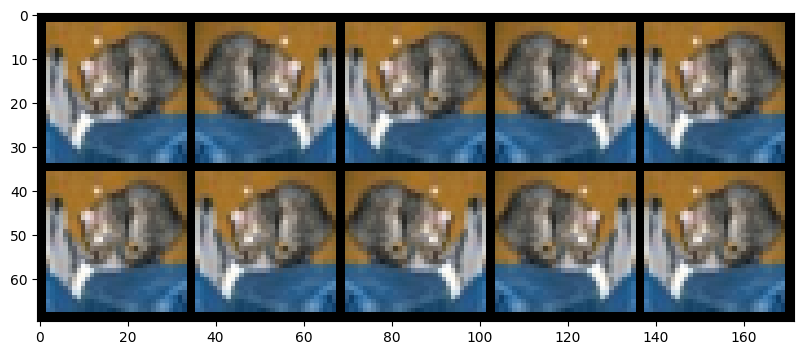

In [27]:
im, _ = test_dataset[0]
im = im[None, ...] # We need a leading batch dimension to feed to the model

images_rot = torch.cat([T.RandomHorizontalFlip()(im) for _ in range(10)])

grid = torchvision.utils.make_grid(images_rot, nrow=5, padding=2)
# Just normalization for test data
plt.figure(figsize=(20,4))
plt.imshow(grid.permute([1,2,0]))

Horizontal flips are a bit obvious. We can get more creative with data augmentation. However, bare in mind that some transformations might destroy important information of your data, so be careful when applying it.

CIFAR10 is relatively easy, so the following transformations are enough to achieve good performance.

In [28]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=[32,32], padding=4)
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(), 
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=test_transform)

# we make the Batch_sizes smaller for computational reasons
# we will later use larger models and memory might become an issue
BATCH_SIZE = 256

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Let's train a **ResNet**! Since it is a standard model, it is already implemented in the `torchvision` library and we can use it directly.

Epoch 0: Loss=1.9169770789389708
Epoch 1: Loss=1.579274063815876
Epoch 2: Loss=1.3318757761497886
Epoch 3: Loss=1.1582318726851015
Epoch 4: Loss=1.0332723366362708
Epoch 5: Loss=0.9399179931806059
Epoch 6: Loss=0.8742503730618224
Epoch 7: Loss=0.8083406057284803
Epoch 8: Loss=0.7580773419871623
Epoch 9: Loss=0.7245379230197595
Epoch 10: Loss=0.6908226302083658
Epoch 11: Loss=0.6617251999524175
Epoch 12: Loss=0.6366182460772748
Epoch 13: Loss=0.6065122691952453
Epoch 14: Loss=0.5847367451203113
Epoch 15: Loss=0.5676680084089843
Epoch 16: Loss=0.5591183788314158
Epoch 17: Loss=0.5307154018355875
Epoch 18: Loss=0.5248129922820597
Epoch 19: Loss=0.49986616005094686
Epoch 20: Loss=0.4873348007700881
Epoch 21: Loss=0.4795758389696783
Epoch 22: Loss=0.4654530143859435
Epoch 23: Loss=0.4580591190226224
Epoch 24: Loss=0.44211880665044395
Epoch 25: Loss=0.43248030117579866
Epoch 26: Loss=0.4234259791520177
Epoch 27: Loss=0.4115765306110285
Epoch 28: Loss=0.4041897601314953
Epoch 29: Loss=0.40141

(0.7244871940612793, tensor(76.9000, device='cuda:0'))

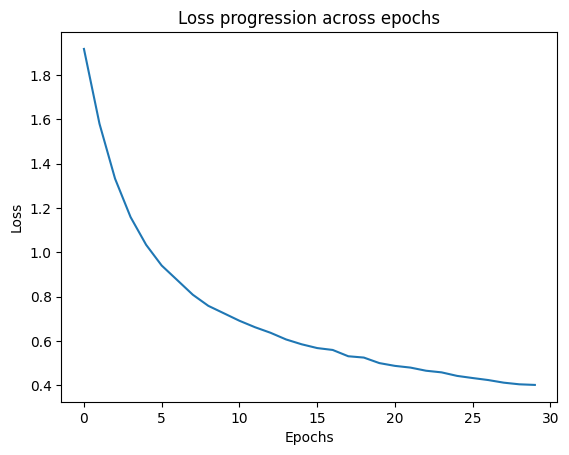

In [29]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.resnet import resnet18

model = resnet18(num_classes=10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
    )
)

# predict with the trained model
predict(
        model,
        test_dataloader = test_dataloader,
        device = DEVICE,
    )

# Transfer learning

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Transfer learning refers to the concept of initializing a neural network using the weights learned on a different task before training. Surprisingly, if the pretraining dataset is large enough, but also semantically ''close'' to the downstream task, using transfer learning, instead of regular training from random weights can significantly boost performance. Intuitively, transfer learning allows to recycle the features learned with a lot of data on the pretraining task, and leverage them to classify a new dataset.

Let's see this in practice. To that end, we will follow the [PyTorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which is an excellent resource to learn how to implement advanced techniques in deep learning. We will minimally adapt the code to fit our streamlined API from the previous labs.

Let's download our data...

In [30]:
!pip install requests
import requests
import os

remote_url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'

local_file = './data/hymenoptera_data.zip'
os.makedirs('./data', exist_ok=True)

data = requests.get(remote_url)

# Save file data to local copy
with open(local_file, 'wb')as file:
    file.write(data.content)

and extract it...

In [31]:
from zipfile import ZipFile
  
# opening the zip file in READ mode
with ZipFile(local_file, 'r') as zip:
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall('./data')
    print('Done!')

Extracting all the files now...
Done!


We can work with this data directly using `torchvision`

In [32]:
# Data augmentation and normalization for training
# The normalization values are the average and std of each channel, precomputed
# on the training images
train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for test data
test_transform =  T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    # Should we add the same normalization for test as we did for train? Explain. Yes, if we do not normalize the test data, the model will not be able to make accurate predictions.
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


data_dir = 'data/hymenoptera_data'
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), test_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

train_size = len(train_dataset)
test_size = len(test_dataset)
class_names = train_dataset.classes

Let's visualize a few images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


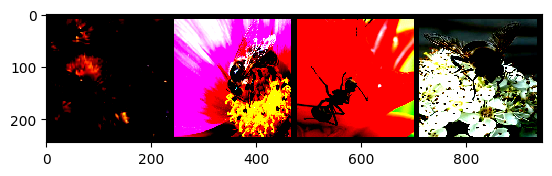

In [33]:
visualize_images(train_dataloader)

There are two major transfer learning techniques depending on which parts of the network are updated using the new data:
1. Finetuning the full network
2. Finetuning only the last layer

First let's see how a randomly initialized model performs!

Epoch 0: Loss=0.7514870943593197
Epoch 1: Loss=0.7854044195569929
Epoch 2: Loss=0.7976216444226562
Epoch 3: Loss=0.7946002500467613
Epoch 4: Loss=0.8133356507684364
Epoch 5: Loss=0.8440139953230248
Epoch 6: Loss=0.9250512980535383
Epoch 7: Loss=0.6933581653188486
Epoch 8: Loss=0.6858602940547661
Epoch 9: Loss=0.677991835553138
Epoch 10: Loss=0.7203158921882754
Epoch 11: Loss=0.743842251232413
Epoch 12: Loss=0.5853486881881463
Epoch 13: Loss=0.6606044070642503
Epoch 14: Loss=0.6843337873454953
Epoch 15: Loss=0.6627680581124102
Epoch 16: Loss=0.6489186792588625
Epoch 17: Loss=0.6929523551561794
Epoch 18: Loss=0.80862821980578
Epoch 19: Loss=0.7646628740381022
Epoch 20: Loss=0.6570779593264471
Epoch 21: Loss=0.681448681676974
Epoch 22: Loss=0.7378170788288116
Epoch 23: Loss=0.6115303958048586
Epoch 24: Loss=0.6246143596582725
Test set: Avg. loss: 0.6387, Accuracy: 103/153 (67%)


(0.6386685686952928, tensor(67.3203, device='cuda:0'))

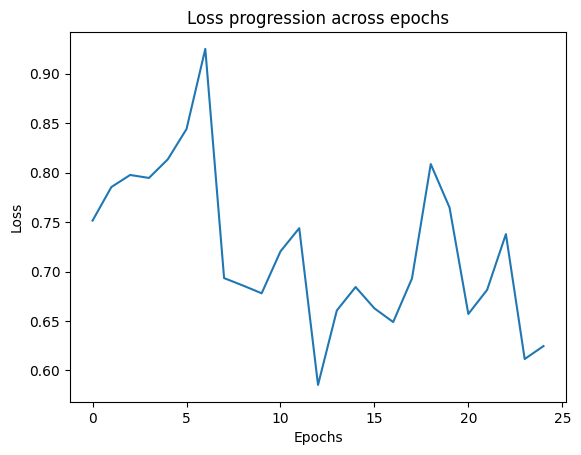

In [34]:
# the model is a resnet18. How many outputs should it have?
model = resnet18(num_classes=2).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the full network
Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. The rest of the training looks as usual, albeit normally using a significantly smaller learning rate.


In [39]:
import torch.nn as nn

class FinetuningFullModel(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        # load pretrained resnet18
        self.network = resnet18(pretrained=True)
        # change the last layer with a randonly initializied one and with `num_classes` number of output neurons.
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, x):
        return self.network(x)

Let's train it...

Epoch 0: Loss=0.5712133915942224
Epoch 1: Loss=0.6432884376129655
Epoch 2: Loss=0.5116274527838973
Epoch 3: Loss=0.4687138540655008
Epoch 4: Loss=0.5344844195442121
Epoch 5: Loss=0.4053609607527491
Epoch 6: Loss=0.4837825754504712
Epoch 7: Loss=0.5592973082036269
Epoch 8: Loss=0.41902326024328285
Epoch 9: Loss=0.4066065741229619
Epoch 10: Loss=0.3405271703377366
Epoch 11: Loss=0.5153007780308606
Epoch 12: Loss=0.5618421501235762
Epoch 13: Loss=0.4322546592180724
Epoch 14: Loss=0.45396581839495265
Epoch 15: Loss=0.4613059090114519
Epoch 16: Loss=0.40122105820738085
Epoch 17: Loss=0.45406455817807956
Epoch 18: Loss=0.5178448774042677
Epoch 19: Loss=0.5844345192298995
Epoch 20: Loss=0.3942136178108039
Epoch 21: Loss=0.5943979603948346
Epoch 22: Loss=0.48823962845843377
Epoch 23: Loss=0.39096338367929345
Epoch 24: Loss=0.49034312185659606
Test set: Avg. loss: 0.4311, Accuracy: 133/153 (87%)


(0.43109058947157836, tensor(86.9281, device='cuda:0'))

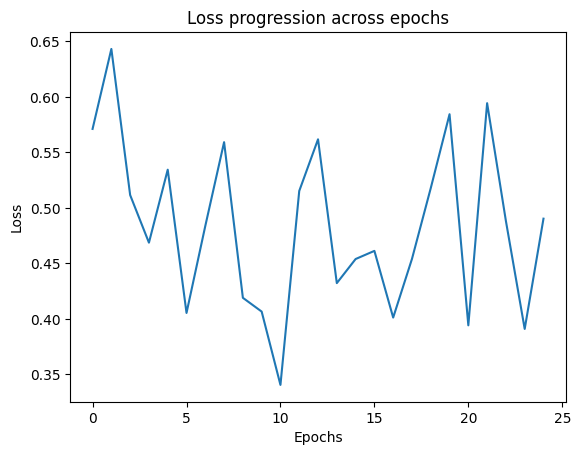

In [41]:
model = FinetuningFullModel(num_classes=2).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the last layer

Sometimes finetuning all the parameters of a large model is too expensive, or unstable. In those cases, one can alternatively 'freeze' some parts of the network, and train only the latter parts. Most often, just tuning the last layer is enough to get good enough results, with the optimal performance normally achieved by finetuning a few of the last layers.

In [42]:
#Sometimes finetuning all the parameters of a large model is too expensive, or unstable. In those cases, one can alternatively 'freeze' some parts of the network, and train only the latter parts. Most often, just tuning the last layer is enough to get good enough results, with the optimal performance normally achieved by finetuning a few of the last layers.

class FinetuningLastLayer(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        # load pretrained resnet18
        self.network = resnet18(pretrained=True)

        # freeze the parameters of the network.
        for param in self.network.parameters():
            param.requires_grad = False

        # replace the last layer with a randonly initializied one and with `num_classes` number of output neurons.
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, x):
        return self.network(x)

Epoch 0: Loss=0.656617915532628
Epoch 1: Loss=0.5235472377695021
Epoch 2: Loss=0.5014385420401566
Epoch 3: Loss=0.30593453011796123
Epoch 4: Loss=0.4261488909909471
Epoch 5: Loss=0.4178569104644607
Epoch 6: Loss=0.5299313521837113
Epoch 7: Loss=0.37469333504922075
Epoch 8: Loss=0.26382859135199277
Epoch 9: Loss=0.3869421095969003
Epoch 10: Loss=0.5322730779861573
Epoch 11: Loss=0.5323615313706095
Epoch 12: Loss=0.6088007722034684
Epoch 13: Loss=0.4391188550145045
Epoch 14: Loss=0.41130938055757127
Epoch 15: Loss=0.4389366496842904
Epoch 16: Loss=0.4152399704287775
Epoch 17: Loss=0.4141206207730975
Epoch 18: Loss=0.36515036522273403
Epoch 19: Loss=0.40054064500527303
Epoch 20: Loss=0.4570935787175034
Epoch 21: Loss=0.29532934430429375
Epoch 22: Loss=0.4388898771454687
Epoch 23: Loss=0.4653920821280631
Epoch 24: Loss=0.6326370957425841
Test set: Avg. loss: 0.3356, Accuracy: 136/153 (89%)


(0.33558017432136505, tensor(88.8889, device='cuda:0'))

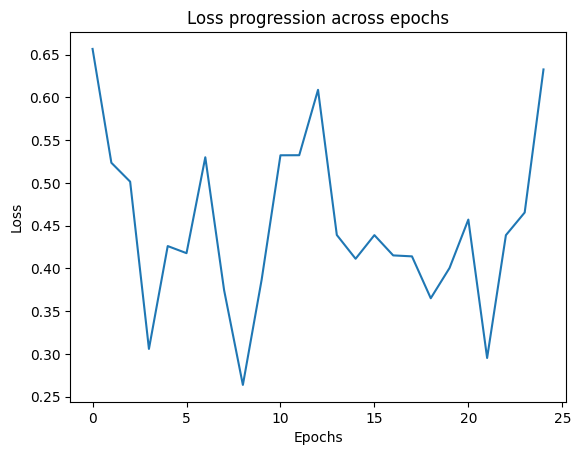

In [43]:
model = FinetuningLastLayer(num_classes=2).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)